## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we use Grad-CAM, which highlights the regions of the input image that were important for the neural network prediction.


* NB: if `PIL` is not installed, try `conda install pillow`.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import pickle
import urllib.request

import numpy as np
from PIL import Image

%matplotlib inline

### Download the Model
We provide you a pretrained model `ResNet-34` for `ImageNet` classification dataset.
* **ImageNet**: A large dataset of photographs with 1 000 classes.
* **ResNet-34**: A deep architecture for image classification.

In [2]:
resnet34 = models.resnet34(weights='ResNet34_Weights.IMAGENET1K_V1')  # New PyTorch interface for loading weights!
resnet34.eval() # set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

![ResNet34](https://miro.medium.com/max/1050/1*Y-u7dH4WC-dXyn9jOG4w0w.png)


Input image must be of size (3x224x224). 

First convolution layer with maxpool. 
Then 4 ResNet blocks. 

Output of the last ResNet block is of size (512x7x7). 

Average pooling is applied to this layer to have a 1D array of 512 features fed to a linear layer that outputs 1000 values (one for each class). No softmax is present in this case. We have already the raw class score!

In [3]:
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

##classes is a dictionary with the name of each class 
print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

### Input Images
We provide you 20 images from ImageNet (download link on the webpage of the course or download directly using the following command line,).<br>
In order to use the pretrained model resnet34, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [4]:
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    # Note: If the inverse normalisation is required, apply 1/x to the above object
    
    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [5]:
import os
if not os.path.exists("../data/"):
    os.mkdir("../data")
if not os.path.exists("../data/raw/"):
    os.mkdir("../data/raw")
    !cd ../data/raw/TP2_images && wget "https://www.lri.fr/~gcharpia/deeppractice/2023/TP2/TP2_images.zip" && unzip TP2_images.zip

dir_path = "../data/raw" 
dataset = preprocess_image(dir_path)

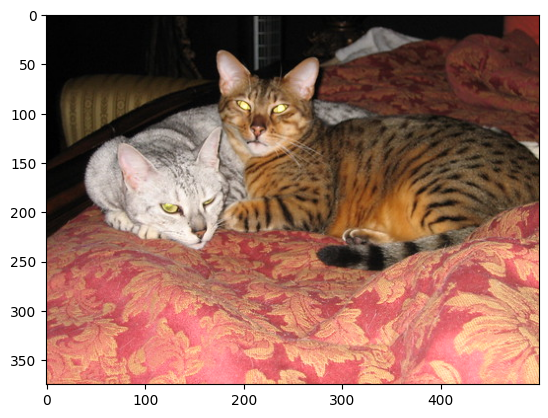

In [6]:
# show the orignal image 
index = 5
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

In [28]:
output = resnet34(dataset[index][0].view(1, 3, 224, 224))
values, indices = torch.topk(output, 3)
print("Top 3-classes:", indices[0].numpy(), [classes[x] for x in indices[0].numpy()])
print("Raw class scores:", values[0].detach().numpy())

Top 3-classes: [285 281 282] ['Egyptian cat', 'tabby, tabby cat', 'tiger cat']
Raw class scores: [13.175315 11.065538 10.584749]


### Grad-CAM 
* **Overview:** Given an image, and a category (‘tiger cat’) as input, we forward-propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the given images. For each image, choose the top-3 possible labels as the desired classes. Compare the heatmaps of the three classes, and conclude. 


* **To be submitted within 2 weeks**: this notebook, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully.
 + More on [autograd](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html) and [hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks)
 + The pretrained model resnet34 doesn't have an activation function after its last layer, the output is indeed the `raw class scores`, you can use them directly. 
 + The size of feature maps is 7x7, so your heatmap will have the same size. You need to project the heatmap to the resized image (224x224, not the original one, before the normalization) to have a better observation. The function [`torch.nn.functional.interpolate`](https://pytorch.org/docs/stable/nn.functional.html?highlight=interpolate#torch.nn.functional.interpolate) may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

Class: ‘pug, pug-dog’ | Class: ‘tabby, tabby cat’
- | - 
![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/dog.jpg)| ![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/cat.jpg)

### Complementary questions:

##### Try GradCAM on others convolutional layers, describe and comment the results

In [29]:
class SaveFeatures():
    """ Extract pretrained features before the final fully connected layer """
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.features = None

    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()

    def close(self):
        self.hook.remove()

In [51]:
import cv2

def save_activation(module, input, output):
    """Forward hook for saving the activation of the convolutional layer"""
    # Attach the output (activation) to the module
    module.activation = output

def save_gradient(module, grad_input, grad_output):
    """Backward hook for saving the gradient with respect to the activation of the convolutional layer"""
    # Attach the gradient (grad_output) to the module
    module.gradient = grad_output[0]

def grad_cam(model, img, target_class):
    model.eval()

    # Register the forward and backward hooks
    final_conv_layer = resnet34.layer4[-1]
    final_conv_layer.register_forward_hook(save_activation)
    final_conv_layer.register_backward_hook(save_gradient)

    output = model(img)
    model.zero_grad()
    
    target = torch.zeros(output.shape)
    target[0][target_class] = 1

    output.backward(gradient=target)

    activations = final_conv_layer.activation
    gradients = final_conv_layer.gradient

    weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
    grad_cam_map = torch.sum(weights * activations, dim=1).squeeze()
    grad_cam_map = F.relu(grad_cam_map)
    grad_cam_map = grad_cam_map / grad_cam_map.max()
    print(grad_cam_map)
    return grad_cam_map


In [58]:
# Load the image
index = 5
image = dataset[index][0].view(1, 3, 224, 224)
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')

In [59]:
outputs = resnet34(image)
_, predicted_class = outputs.max(dim=1)
print(predicted_class)

tensor([285])


/opt/anaconda3/envs/EC-DeepLearning/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [60]:
grad_cam_map = grad_cam(resnet34, image, predicted_class.item())

tensor([[0.1343, 0.2260, 0.3158, 0.2865, 0.1937, 0.2221, 0.1681],
        [0.2595, 0.4668, 0.6857, 0.7052, 0.4781, 0.4531, 0.3424],
        [0.4881, 0.8088, 0.7900, 0.8502, 0.7153, 0.7340, 0.6543],
        [0.6855, 1.0000, 0.7832, 0.8150, 0.7295, 0.8136, 0.7165],
        [0.6409, 0.8216, 0.5741, 0.4837, 0.4017, 0.5498, 0.4965],
        [0.2807, 0.3752, 0.2718, 0.2498, 0.2220, 0.3129, 0.2480],
        [0.0700, 0.1117, 0.0812, 0.0776, 0.0638, 0.0969, 0.0956]],
       grad_fn=<DivBackward0>)


In [61]:
# Function to apply the heatmap on the image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    plt.imshow(np.uint8(255 * cam))
    plt.show()

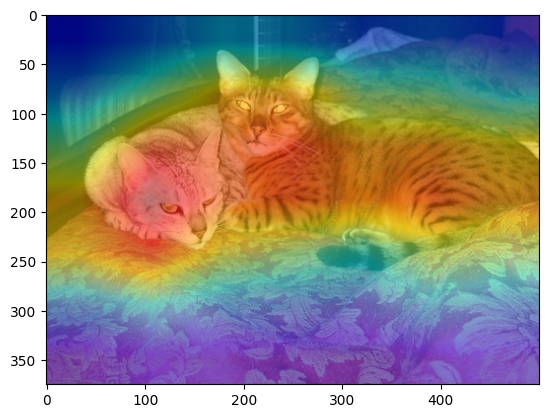

In [64]:
# Convert the tensor to numpy for visualization
grad_cam_map_np = grad_cam_map.cpu().detach().numpy()
grad_cam_map_np = 1.0 - grad_cam_map_np
grad_cam_map_resized = cv2.resize(grad_cam_map_np, (input_image.width, input_image.height))

# Prepare the original image
img_np = np.array(input_image) / 255.0

# Show the heatmap overlayed on the original image
show_cam_on_image(img_np, grad_cam_map_resized)

Hot fix with 1 - grad map

#TODO understand why I got reverse grad map

##### What are the principal contributions of GradCAM (the answer is in the paper) ?